In [2]:
import neat
import visualize

import os
import multiprocessing

import random

import pickle
import gzip

from time import time

In [3]:
def z_to_1(z):
    if z < 0.0:
        return 0.0
    elif z > 1.0:
        return 1.0
    else:
        return z

def yes_no(z):
    return 1 if z > 0.0 else 0.0

start_config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "starting_config")

start_config.genome_config.add_activation('zero_to_one', z_to_1)
start_config.genome_config.add_activation('yes_or_no', yes_no)

In [4]:
def create_correct_genome(size):
    squares = (size[0]*size[1])**2
    genome = neat.DefaultGenome(0)
    
    genome.nodes = {}
    for i in range(squares):
        node = neat.genes.DefaultNodeGene(i)
        node.bias = 1.0
        node.response = 1.0
        node.activation = "zero_to_one"
        node.aggregation = "sum"
        genome.nodes[i] = node
    
    genome.connections = {}
    for i in range(squares):
        gene = neat.genes.DefaultConnectionGene((-(i+1),i))
        gene.weight = -1.0
        gene.enabled = True
        genome.connections[(-(i+1),i)] = gene
    
    return genome

sizes = [(2,2), (2,3), (3,3), (3,4), (4,4)]
for size in sizes:
    size_genome = create_correct_genome(size)
    
    with gzip.open(f'correct_genomes/correct_genome-{str(size)}', 'w', compresslevel=5) as f:
        pickle.dump(size_genome, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
def create_points_genome(size):
    length = size[0]*size[1]
    squares = length**2
    genome = neat.DefaultGenome(0)
    
    genome.nodes = {}
    genome.connections = {}
    
    node_key = squares
    
    def rc2f(i, j):
        return i*length + j
    
    def f2rc(k):
        return k // length , k % length 
    
    def f2region(k):
        i,j = f2rc(k)
        return i - i %size[0] + j//size[1]
        
    
    for i in range(squares):
        cor_X, cor_Y = f2rc(i)
        
        # Create row node
        node = neat.genes.DefaultNodeGene(node_key)
        node.bias = -length + 1.2
        node.response = 1.0
        node.activation = "yes_or_no"
        node.aggregation = "sum"
        genome.nodes[node_key] = node
        
        # Add row node connections
        for j in range(length):
            if j != cor_Y:
                square_connect = rc2f(cor_X, j)
                gene = neat.genes.DefaultConnectionGene((-(square_connect+1),node_key))
                gene.weight = 1.0
                gene.enabled = True
                genome.connections[(-(square_connect+1),node_key)] = gene
        
        node_key += 1
        
        # Create column node
        node = neat.genes.DefaultNodeGene(node_key)
        node.bias = -length + 1.2
        node.response = 1.0
        node.activation = "yes_or_no"
        node.aggregation = "sum"
        genome.nodes[node_key] = node
        
        # Add column node connections
        for j in range(length):
            if j != cor_X:
                square_connect = rc2f(j, cor_Y)
                gene = neat.genes.DefaultConnectionGene((-(square_connect+1),node_key))
                gene.weight = 1.0
                gene.enabled = True
                genome.connections[(-(square_connect+1),node_key)] = gene
        
        node_key += 1
        
        # Create region node
        node = neat.genes.DefaultNodeGene(node_key)
        node.bias = -length + 1.2
        node.response = 1.0
        node.activation = "yes_or_no"
        node.aggregation = "sum"
        genome.nodes[node_key] = node
        
        # Add region node connections
        region = f2region(i)
        for j in range(squares):
            if (region == f2region(j)) & (i != j):
                gene = neat.genes.DefaultConnectionGene((-(j+1),node_key))
                gene.weight = 1.0
                gene.enabled = True
                genome.connections[(-(j+1),node_key)] = gene
        
        # Create result node
        node = neat.genes.DefaultNodeGene(i)
        node.bias = 0.0
        node.response = 0.333
        node.activation = "zero_to_one"
        node.aggregation = "sum"
        genome.nodes[i] = node
        
        # Add result connections
        for j in range(0,3):
            gene = neat.genes.DefaultConnectionGene((node_key-j,i))
            gene.weight = 1.0
            gene.enabled = True
            genome.connections[(node_key-j,i)] = gene
        
        # Add a direct input output connection
        gene = neat.genes.DefaultConnectionGene((-(i+1),i))
        gene.weight = -10
        gene.enabled = True
        genome.connections[(-(i+1),i)] = gene
        
        node_key += 1

    return genome

sizes = [(2,2), (2,3), (3,3), (3,4), (4,4)]
for size in sizes:
    size_genome = create_points_genome(size)
    
    with gzip.open(f'points_genomes/points_genome-{str(size)}', 'w', compresslevel=5) as f:
        pickle.dump(size_genome, f, protocol=pickle.HIGHEST_PROTOCOL)

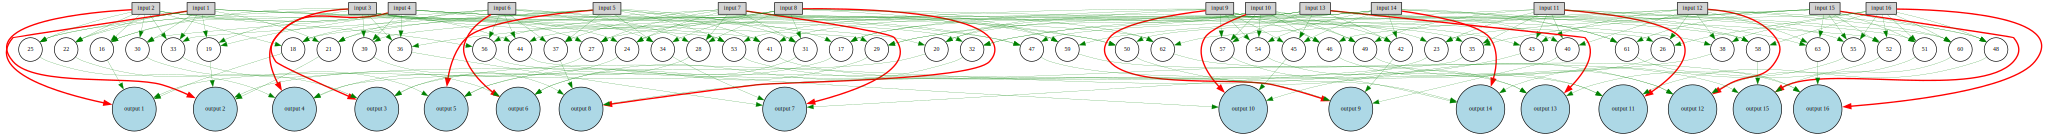

In [6]:
size = (2,2)

size_genome = create_points_genome(size)
squares = (size[0]*size[1])**2

#start_config.num_inputs = (size[0]*size[1])**2
#start_config.num_outputs = (size[0]*size[1])**2
start_config.genome_config.input_keys = [-(i+1) for i in range(squares)]
start_config.genome_config.output_keys = [i for i in range(squares)]

node_names = {}
for i in range(1, squares + 1):
    node_names[-i] = f"input {i}"
    node_names[i-1] = f"output {i}"
    
visualize.draw_net(start_config, size_genome, True, node_names=node_names, prune_unused=True)

In [8]:
print(size_genome)

Key: 0
Fitness: None
Nodes:
	16 DefaultNodeGene(key=16, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	17 DefaultNodeGene(key=17, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	18 DefaultNodeGene(key=18, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	0 DefaultNodeGene(key=0, bias=0.0, response=0.333, activation=zero_to_one, aggregation=sum)
	19 DefaultNodeGene(key=19, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	20 DefaultNodeGene(key=20, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	21 DefaultNodeGene(key=21, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=0.333, activation=zero_to_one, aggregation=sum)
	22 DefaultNodeGene(key=22, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	23 DefaultNodeGene(key=23, bias=-2.8, response=1.0, activation=yes_or_no, aggregation=sum)
	24 DefaultNodeGene(key=24, bias=-2.8, response=1.